# Load data

In [2]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycode_similar
import re
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


from base64 import b64decode
def decode_program(code):
    return b64decode(code).decode("utf-8")

In [28]:
exercise_df = pd.read_csv("exercise.csv")
ipython = exercise_df[exercise_df["name"] == "IPython"]

log_df = pd.read_csv('data/umimeprogramovatcz-ipython_log.csv', sep=';')
questions_df = pd.read_csv('data/umimeprogramovatcz-ipython_item.csv', sep=';', index_col='id')
log_df.drop(list(range(424)), inplace=True)
log_df.reset_index(inplace=True, drop=True)

## Exercise dataframe

In [51]:
exercise_df

,id,name,short,type,questions,log,column,dropMode,hasRT,sumTime,globalMaxTime,doBoxplot,sortCriterium,fromTime
0,1,Doplňovačka stará,xxx,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0,0,NaN
1,2,Otázky staré,yyy,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0,0,NaN
2,3,Diktáty,diktaty,medal,dictate.csv,dictate_session_log.csv,dictate,NaN,0.0,0.0,0.0,0,0,NaN
3,4,Čárky,carky,medal,carky_sentence.csv,carky_sentence_log.csv,sentence,NaN,0.0,0.0,0.0,0,0,NaN
4,5,Rozbory,rozbory,medal,vetne_cleny_sentence.csv,vetne_cleny_log.csv,sentence,NaN,1.0,0.0,0.0,0,0,2018-01-01
5,6,Vtipy,vtipy,item,vtipy_joke.csv,vtipy_log.csv,item,NaN,1.0,1.0,0.0,0,0,NaN
6,7,Roboti,roboti,level,NaN,roboti_session_log.csv,NaN,NaN,1.0,0.0,0.0,0,0,NaN
7,8,Střílečka,stril,level,NaN,shooter_session_log.csv,NaN,NaN,1.0,0.0,0.0,0,0,NaN
8,9,Tetris,tetris,level,NaN,tetris_session_log.csv,NaN,NaN,1.0,0.0,0.0,0,0,NaN
9,10,Závody,zavody,multi,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0,0,NaN


## IPython record (from exercise_df)

In [4]:
ipython

,id,name,short,type,questions,log,column,dropMode,hasRT,sumTime,globalMaxTime,doBoxplot,sortCriterium,fromTime
33,35,IPython,ipython,item,ipython_item.csv,ipython_log.csv,item,keep_only_last,1.0,0.0,1.0,1,ordering,2018-02-21


## Log dataframe

In [5]:
log_df.head(10)

,id,user,item,answer,correct,moves,responseTime,time
0,1966,1625382,13,ZGVmIHN0cmluZ19pbnRlcnNlY3Rpb24obGVmdCwgcmlnaH...,1,-1,423250,2017-12-06 15:12:17
1,1967,1625382,14,ZGVmIHBhbGluZHJvbSh0ZXh0KTpicmVhayAgICBpZiBsZW...,1,-1,730000,2017-12-06 16:10:43
2,1976,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,28350,2017-12-06 17:44:30
3,1977,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,55100,2017-12-06 17:44:57
4,1979,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,151500,2017-12-06 17:46:33
5,1980,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,193900,2017-12-06 17:48:45
6,1981,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,194850,2017-12-06 17:48:46
7,1982,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,195700,2017-12-06 17:48:47
8,1983,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,196300,2017-12-06 17:48:47
9,1984,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,196650,2017-12-06 17:48:48


In [29]:
log_df = log_df.drop_duplicates(['user', 'item', 'answer', 'correct'])

## Questions dataframe

In [26]:
questions_df

,name,instructions,democode,testcode,solution,tests,medianTime,ordering,visible,created
id,,,,,,,,,,
1,Výpis čísel,"[[""html"",""Napište funkci <b>numbers(n)</b>, kt...","[[""python64"",""ZGVmIG51bWJlcnMobik6CiAgICBwcmlu...","[[""python64"",""bnVtYmVycygxMCkK""]]","[[""python64"",""ZGVmIG51bWJlcnMobik6CiAgICBmb3Ig...","[[""python64"",""bnVtYmVycygzKQo=""],[""python64"",""...",136380,1,1,2017-11-21 18:17:19
2,Fibonacciho posloupnost,"[[""html"",""Napište funkci <b>fibonacci(n)</b>, ...","[[""python64"",""ZGVmIGZpYm9uYWNjaShuKToKICAgIGZv...","[[""python64"",""Zmlib25hY2NpKDEwKQo=""]]","[[""python64"",""ZGVmIGZpYm9uYWNjaShuKToKICAgIGN1...","[[""python64"",""Zmlib25hY2NpKDUpCg==""],[""python6...",136380,7,1,2017-11-21 18:17:19
3,Faktoriál,"[[""html"",""Napište funkci <b>factorial(n)</b> v...","[[""python64"",""ZGVmIGZhY3RvcmlhbChuKToKICAgIHJl...","[[""python64"",""cHJpbnQoZmFjdG9yaWFsKDUpKQo=""]]","[[""python64"",""ZGVmIGZhY3RvcmlhbChuKToKICAgIHZh...","[[""python64"",""cHJpbnQoZmFjdG9yaWFsKDYpKQo=""],[...",136380,7,1,2017-11-21 18:17:19
4,Abeceda,"[[""html"",""Napište funkci <b>alphabet(n)</b>, k...","[[""python64"",""ZGVmIGFscGhhYmV0KG4pOgogICAgZm9y...","[[""python64"",""YWxwaGFiZXQoMzApCg==""]]","[[""python64"",""ZGVmIGFscGhhYmV0KG4pOgogICAgZm9y...","[[""python64"",""YWxwaGFiZXQoMTApCg==""],[""python6...",136380,10,1,2017-11-21 18:17:19
5,Zdvojení znaků,"[[""html"",""Napište funkci <b>duplication(text)<...","[[""python64"",""ZGVmIGR1cGxpY2F0aW9uKHRleHQpOgog...","[[""python64"",""cHJpbnQoZHVwbGljYXRpb24oIlBZVEhP...","[[""python64"",""ZGVmIGR1cGxpY2F0aW9uKHRleHQpOgog...","[[""python64"",""cHJpbnQoZHVwbGljYXRpb24oIkFBIikp...",193233,3,1,2017-11-21 18:17:19
6,Součin nenulových,"[[""html"",""Napište funkci <b>nonzero_product(nu...","[[""python64"",""ZGVmIG5vbnplcm9fcHJvZHVjdChudW1i...","[[""python64"",""cHJpbnQobm9uemVyb19wcm9kdWN0KFs0...","[[""python64"",""ZGVmIG5vbnplcm9fcHJvZHVjdChudW1i...","[[""python64"",""cHJpbnQobm9uemVyb19wcm9kdWN0KFsw...",149201,2,1,2017-11-21 18:17:19
7,Dělitelé,"[[""html"",""Napište funkci <b>divisors(n)</b>, k...","[[""python64"",""ZGVmIGRpdmlzb3JzKG4pOgogICAgcHJp...","[[""python64"",""ZGl2aXNvcnMoMjQpCg==""]]","[[""python64"",""ZGVmIGRpdmlzb3JzKG4pOgogICAgZm9y...","[[""python64"",""ZGl2aXNvcnMoNSkK""],[""python64"",""...",193233,1,1,2017-11-21 18:17:19
8,Čtverec,"[[""html"",""Napište funkci <b>square(n)</b>, kte...","[[""python64"",""ZGVmIHNxdWFyZShuKToKICAgIGZvciBp...","[[""python64"",""c3F1YXJlKDUpCg==""]]","[[""python64"",""ZGVmIHNxdWFyZShuKToKICAgIGZvciBp...","[[""python64"",""c3F1YXJlKDMpCg==""],[""python64"",""...",193233,1,1,2017-11-21 18:17:19
9,Prázdný čtverec,"[[""html"","" Napište funkci <b>empty_square(n)</...","[[""python64"",""ZGVmIGVtcHR5X3NxdWFyZShuKToKICAg...","[[""python64"",""ZW1wdHlfc3F1YXJlKDUpCg==""]]","[[""python64"",""ZGVmIGVtcHR5X3NxdWFyZShuKToKICAg...","[[""python64"",""ZW1wdHlfc3F1YXJlKDYpCg==""],[""pyt...",193233,2,1,2017-11-21 18:17:19


In [7]:
questions_df.at[1, 'testcode'][2:-2].split(',')[1].replace('"', '')

'bnVtYmVycygxMCkK'

# Filter only decodable answers

In [30]:
valid = ['True' for _ in range(log_df.shape[0])]
log_df['valid'] = valid

for index, answer in log_df['answer'].items():
    try:
        decode_program(answer)
    except:
        log_df.at[index, 'valid'] = 'False'

In [31]:
log_df = log_df[log_df['valid'] == 'True']
log_df['code'] = log_df.answer.apply(decode_program)

## Filtered log dataframe
Also drop 'valid' column and add 'codeLength' column.

In [32]:
log_df.drop('valid', axis=1, inplace=True)

In [33]:
def get_code_length(code):
    length = code.count("break") + code.count("\n")
    if code.count("\n") > 0:
        length += 1
    return length

log_df['codeLength'] = log_df.code.apply(get_code_length)

In [34]:
log_df.reset_index(inplace=True, drop=True)
log_df.head(10)

,id,user,item,answer,correct,moves,responseTime,time,code,codeLength
0,1976,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,28350,2017-12-06 17:44:30,def find_longest_word(words_list):break ret...,2
1,1979,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,151500,2017-12-06 17:46:33,def find_longest_word(words_list):break,1
2,1985,1518209,31,YnJlYWs=,0,-1,264550,2017-12-06 17:49:56,break,1
3,2019,1579127,35,YnJlYWs=,0,-1,15650,2017-12-07 16:02:46,break,1
4,2020,1579127,35,YnJlYWtURVJFWktBIA==,0,-1,26450,2017-12-07 16:02:57,breakTEREZKA,1
5,2023,33163,34,ZGVmIG11bHRpcGxlcyhuKTpicmVhayAgICBwcmludCgiRH...,0,-1,10700,2017-12-07 16:26:00,"def multiples(n):break print(""Dvojnasobek"",...",2
6,2032,1162084,1,ZGVmIG51bWJlcnMoMTApOmJyZWFrICAgIHByaW50KDEwKW...,0,-1,19350,2017-12-07 17:35:02,def numbers(10):break print(10)break,2
7,2033,1162084,1,ZGVmIG51bWJlcnMoMyk6YnJlYWsgICAgcHJpbnQoMylicm...,0,-1,53100,2017-12-07 17:35:36,def numbers(3):break print(3)break,2
8,2034,1162084,34,YnJlYWs=,0,-1,71850,2017-12-07 17:38:14,break,1
9,2037,1162084,34,NmJyZWFr,0,-1,163150,2017-12-07 17:44:35,6break,1


# Statistics


In [10]:
g_min = log_df.groupby("item").min().add_suffix('Min')
g_mean = log_df.groupby("item").mean().add_suffix('Mean')
g_max = log_df.groupby("item").max().add_suffix('Max')

In [11]:
stats_df = pd.concat([g_min, g_mean, g_max], axis=1, sort=False)
stats_df = stats_df[['correctMean', 'responseTimeMin', 'responseTimeMean', 'responseTimeMax',
                    'codeLengthMin', 'codeLengthMean', 'codeLengthMax']]
stats_df['numAnswers'] = log_df.groupby("item").count()["id"]
stats_df.reset_index(inplace=True)
stats_df.responseTimeMean = stats_df.responseTimeMean.round().astype(int)
stats_df.codeLengthMean = stats_df.codeLengthMean.round().astype(int)

In [12]:
stats_df.sort_values(by=['correctMean'])

,item,correctMean,responseTimeMin,responseTimeMean,responseTimeMax,codeLengthMin,codeLengthMean,codeLengthMax,numAnswers
34,36,0.301088,900,142504,4772300,0,7,525,827
32,34,0.353457,550,168156,16016950,0,5,352,3081
61,63,0.358130,2050,193936,3751250,0,5,17,1519
3,4,0.378531,900,1019539,11681250,0,9,36,177
67,69,0.412371,3850,1339929,8715850,3,19,49,97
28,30,0.423358,4900,828249,5621100,3,13,39,137
11,12,0.427586,5050,1182801,13651500,1,11,38,145
41,43,0.436145,900,350841,2500600,5,10,24,415
52,54,0.442903,900,414081,31106600,2,7,19,937
26,28,0.468468,5950,857352,7135800,1,13,23,111


In [13]:
stats_df.sort_values(by=['numAnswers'])

,item,correctMean,responseTimeMin,responseTimeMean,responseTimeMax,codeLengthMin,codeLengthMean,codeLengthMax,numAnswers
72,74,0.558824,3400,2495154,9200850,4,19,56,34
37,39,0.519481,4500,3151419,88672800,3,14,51,77
71,73,0.590909,7550,1222244,5179600,4,16,50,88
70,72,0.621053,6750,586881,2900200,2,12,25,95
67,69,0.412371,3850,1339929,8715850,3,19,49,97
26,28,0.468468,5950,857352,7135800,1,13,23,111
18,19,0.565574,8650,809775,8551650,3,13,38,122
42,44,0.666667,6950,447978,2666550,3,6,13,126
21,22,0.503876,8850,1259606,7183450,2,14,29,129
28,30,0.423358,4900,828249,5621100,3,13,39,137


# Plots
Following graphs (statistics) are computed from every solution attempt, not only final solutions.

### Success rate

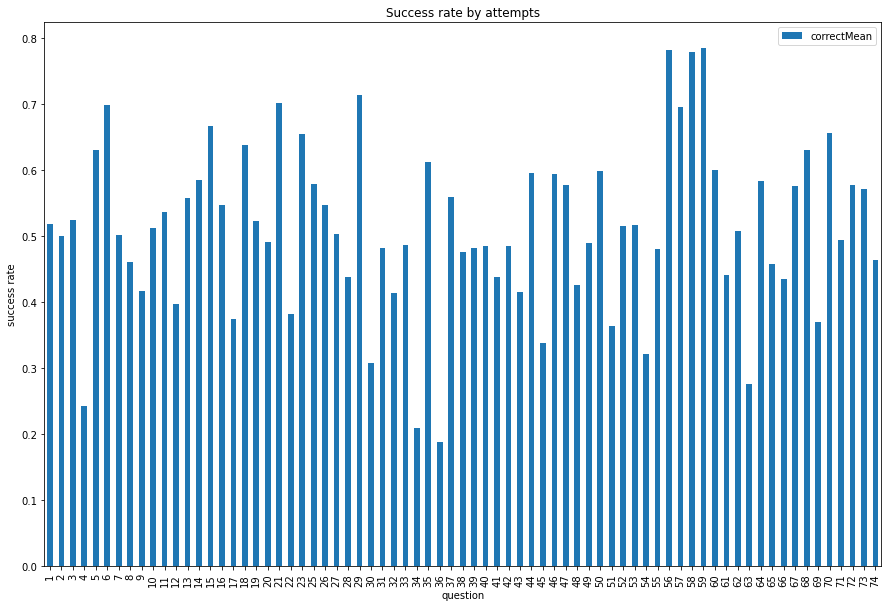

In [17]:
ax = plt.gca()

stats_df.plot(kind='bar', x='item', y='correctMean', title='Success rate by attempts', figsize=(15, 10), ax=ax)

ax.set_ylabel('success rate')
ax.set_xlabel('question')
plt.show()

### Response time
Minimum, average and maximum response time for each question.

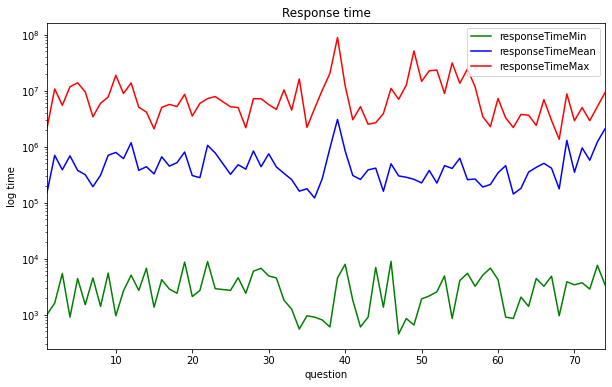

In [18]:
ax = plt.gca()

stats_df.plot(kind='line', x='item', y='responseTimeMin', color='green', logy=True, figsize=(10, 6),
              title="Response time", ax=ax) 
stats_df.plot(kind='line', x='item', y='responseTimeMean', color='blue', logy=True, ax=ax)
stats_df.plot(kind='line', x='item', y='responseTimeMax', color='red', logy=True, ax=ax)

ax.set_ylabel('log time')
ax.set_xlabel('question')
plt.show()

### Code length in lines
Lowest, average and highest number of lines for each question.

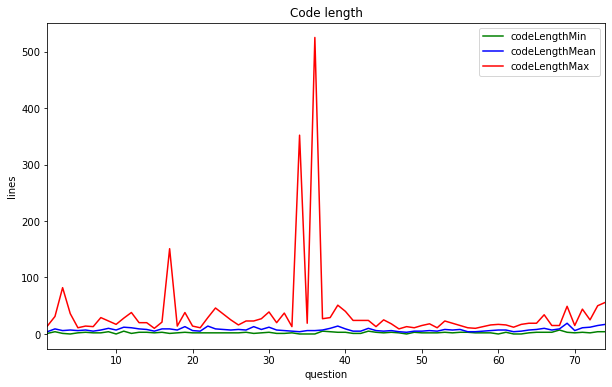

In [19]:
ax = plt.gca()

stats_df.plot(kind='line', x='item', y='codeLengthMin', color='green', figsize=(10, 6), title="Code length", ax=ax) 
stats_df.plot(kind='line', x='item', y='codeLengthMean', color='blue', ax=ax)
stats_df.plot(kind='line', x='item', y='codeLengthMax', color='red', ax=ax)

ax.set_ylabel('lines')
ax.set_xlabel('question')
plt.show()

## Features

In [14]:
# def, print, loop, ifelse, math, compare, assign
features_names = ['def', 'print', 'loop', 'ifelse', 'math', 'compare', 'assign']
features_regex = ['def ', 'print\(', 'for |while ', '\sif |\selif |\selse:', 
            '[^"](\+|\-|\*|/|\+\+|\-\-|%)[^"]', '[^"](<|<=|>|>=|==| is )[^"]', '[^=\+\-\*/"]=[^="]']

# PCA

### What happens here:

Extract few features about each record in task.

Use PCA on these features.

Plot top 2 PCA components in scatter plot.

The colour in plots represents the 'correct' column in the dataframe - whether the answer was correct or not. Yellow points are correct answers, dark point are incorrect answers.

In [15]:
scaler = StandardScaler()
pca = PCA()

def decode_ast(solution):
    try:
        ast.parse(solution)
        return True
    except Exception:
        return False

In [16]:
def compute_features(item, correct_only=False, incorrect_only=False):
    task_df = log_df[log_df['item'] == item]
    if correct_only:
        task_df = task_df[task_df['correct'] == 1]
    elif incorrect_only:
        task_df = task_df[task_df['correct'] == 0]
    solution = questions_df.at[item, 'solution'][2:-2].split(',')[1].replace('"', '')
    solution = decode_program(solution)
    
    # Find ast-parsable solutions
    parsed = task_df.code.apply(decode_ast)
    
    # Pick only ast-parsable solutions
    task_df = pd.DataFrame(task_df[parsed])
    
    # Compute similarity to solution code
    similarities = pycode_similar.detect([solution, *task_df.code.values])
    sim_perc = np.array([x[1][0].plagiarism_percent for x in similarities])
    task_df["sim_perc_sol"] = sim_perc
    
    # Compute answer's ast length (abstract syntax tree)
    ast_len = []
    
    for x in similarities:
        if x[1][0].info_candidate is not None:
            ast_len.append(len(x[1][0].info_candidate.func_ast_lines))
        else:
            ast_len.append(0)
            
    task_df['ast_len'] = ast_len
    
    # Compute similarity to closest correct answer
    correct_codes = task_df[task_df['correct'] == 1].code.values.tolist()
    correct_codes.append(solution)
    sim_perc_closest = []
    feature_dict = {}
    for regex in features_regex:
        feature_dict[regex] = []
    
    for index, row in task_df.iterrows():
        if row['correct'] == 1:
            sim_perc_closest.append(1)
        else:
            try:
                similarities = pycode_similar.detect([row['code'], *correct_codes])
                sim_perc = [x[1][0].plagiarism_percent for x in similarities]
                closest = max(sim_perc)
            except:
                closest = 0
            sim_perc_closest.append(closest)
            
        # Get feature vectors
        for feature in feature_dict:
            feature_count = len(re.findall(feature, row['code']))
            feature_dict[feature].append(feature_count)
    
    # Add new columns
    task_df['sim_perc_closest'] = sim_perc_closest
    
    for regex, name in zip(features_regex, features_names):
        task_df[name] = feature_dict[regex]
    
    return task_df

## Difficulty based on success rate
I picked two tasks for each difficulty level.

Easy: 56, 58, 57, 70

Medium: 11, 16, 33, 42

Hard: 30, 45, 34, 36

One set: [56, 58, 11, 16, 30, 45]   Other set: [57, 70, 33, 42, 34, 36]

### PCA on all solutions

Colored by similarity to closest correct solution

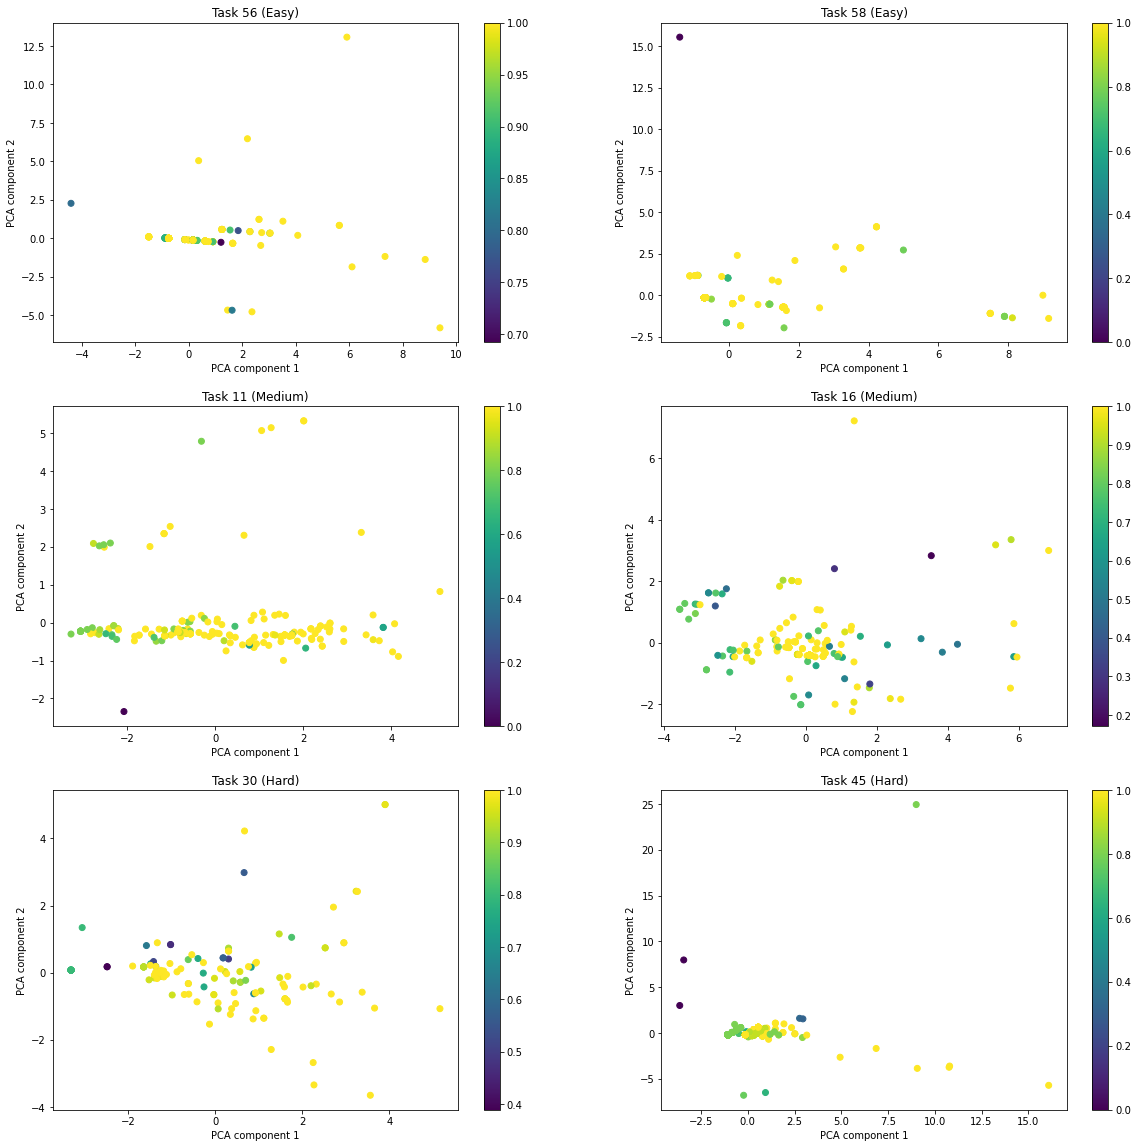

In [70]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))

for item, dif, plt_row, plt_col in zip([56, 58, 11, 16, 30, 45],
                                       ["Easy", "Easy", "Medium", "Medium", "Hard", "Hard"],
                                       [0, 0, 1, 1, 2, 2],
                                       [0, 1, 0, 1, 0, 1]):
    task_df = compute_features(item)
            
    # Drop unnecessary columns
    task_df_trimmed = task_df.drop(['id', 'item', 'user', 'time', 'answer', 'code', 'moves', 'responseTime', 
                                    'correct', 'codeLength', 'sim_perc_sol', 'sim_perc_closest'],
                                    axis=1)
    
    # Scale the columns and perform pca
    pca_components = pca.fit_transform(scaler.fit_transform(task_df_trimmed[[x for x in task_df_trimmed.columns]]))
    
    # Plot
    ax = axes[plt_row, plt_col]
    im = ax.scatter(*pca_components.T[:2], c=task_df['sim_perc_closest'])
    ax.set_title("Task {} ({})".format(item, dif))
    ax.set_ylabel('PCA component 2')
    ax.set_xlabel('PCA component 1')
    fig.colorbar(im, ax=ax)

plt.show()

## PCA on correct solutions only

Colored by similarity to example solution

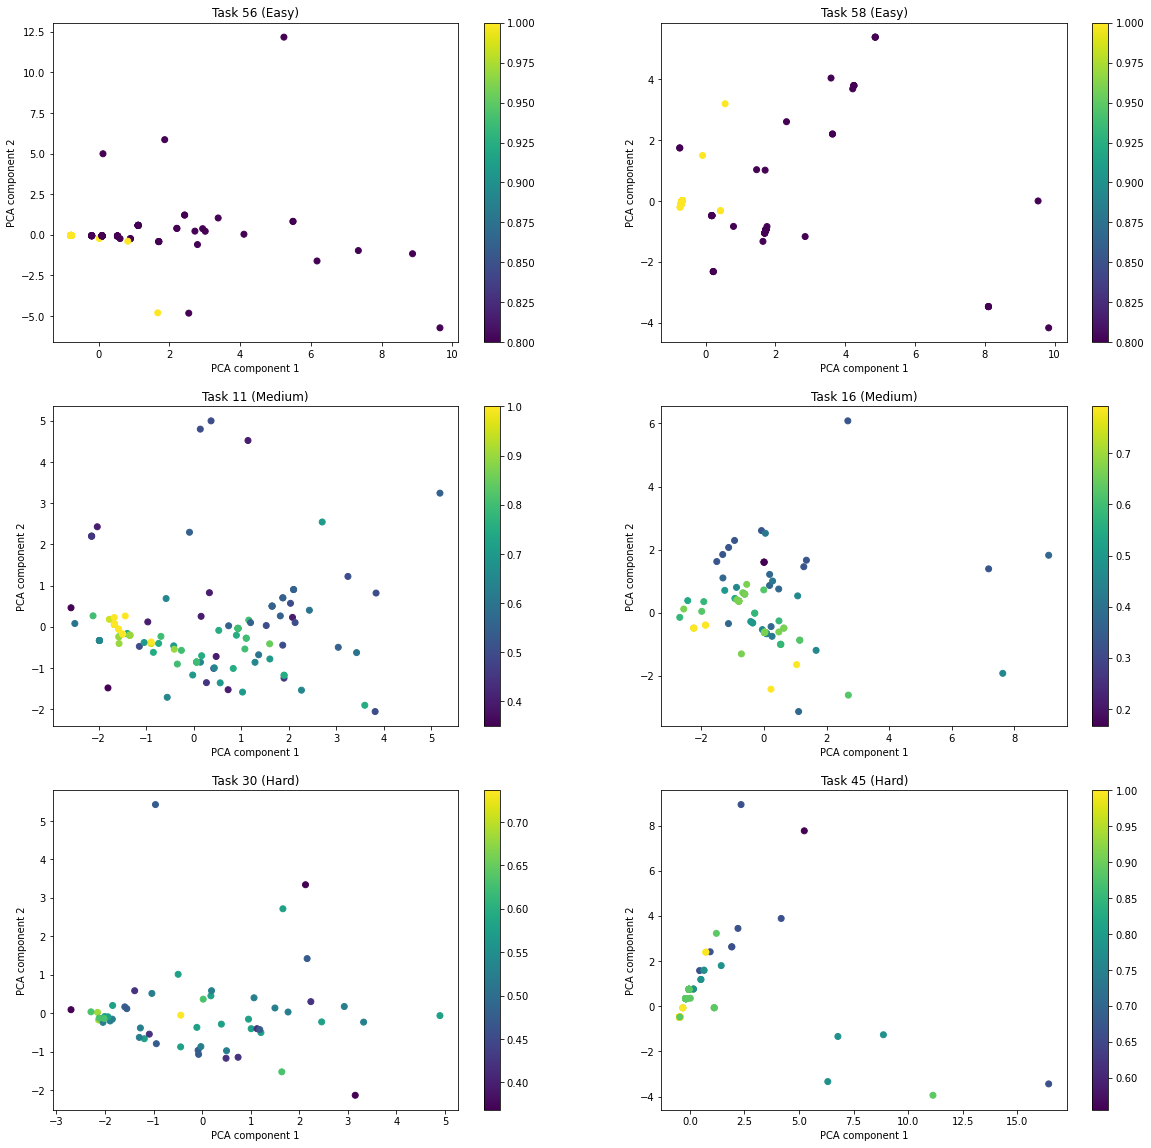

In [71]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))

for item, dif, plt_row, plt_col in zip([56, 58, 11, 16, 30, 45],
                                       ["Easy", "Easy", "Medium", "Medium", "Hard", "Hard"],
                                       [0, 0, 1, 1, 2, 2],
                                       [0, 1, 0, 1, 0, 1]):
    task_df = compute_features(item, correct_only=True)
            
    # Drop unnecessary columns
    task_df_trimmed = task_df.drop(['id', 'item', 'user', 'time', 'answer', 'code', 'moves', 'responseTime', 
                                    'correct', 'codeLength', 'sim_perc_sol', 'sim_perc_closest'],
                                    axis=1)
    
    # Scale the columns and perform pca
    pca_components = pca.fit_transform(scaler.fit_transform(task_df_trimmed[[x for x in task_df_trimmed.columns]]))
    
    # Plot
    ax = axes[plt_row, plt_col]
    im = ax.scatter(*pca_components.T[:2], c=task_df['sim_perc_sol'])
    ax.set_title("Task {} ({})".format(item, dif))
    ax.set_ylabel('PCA component 2')
    ax.set_xlabel('PCA component 1')
    fig.colorbar(im, ax=ax)

plt.show()

# tSNE

### tSNE on all solutions

Colored by similarity to closest corrent solution

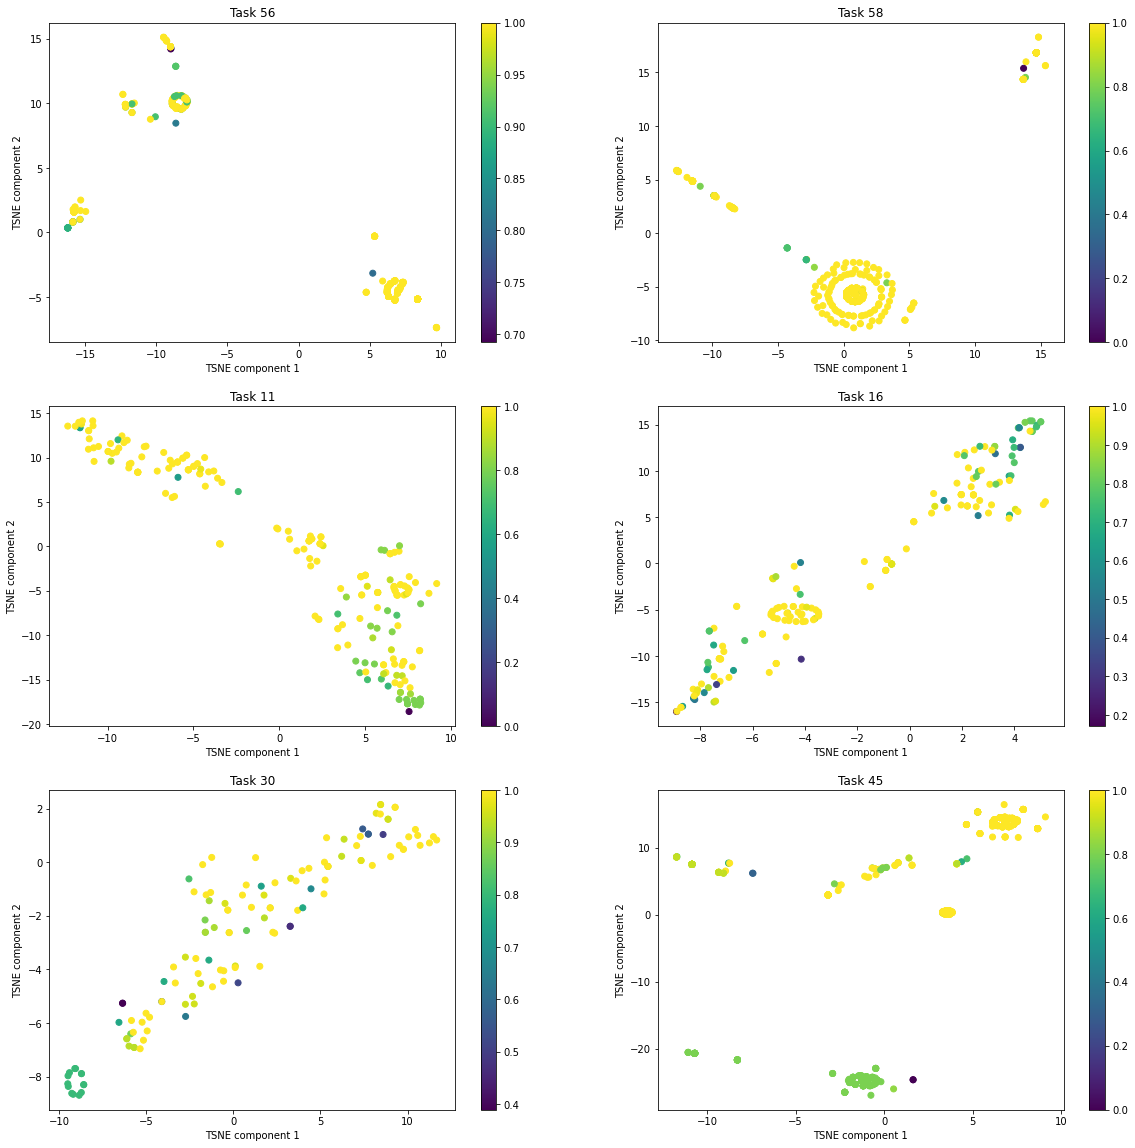

In [113]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))

for item, plt_row, plt_col in zip([56, 58, 11, 16, 30, 45],
                                  [0, 0, 1, 1, 2, 2],
                                  [0, 1, 0, 1, 0, 1]):
    task_df = compute_features(item)
            
    # Drop unnecessary columns
    correct = task_df.correct
    task_df_trimmed = task_df.drop(['id', 'item', 'user', 'time', 'answer', 'code', 'moves', 'responseTime', 
                                    'correct', 'codeLength', 'sim_perc_sol', 'sim_perc_closest'],
                                    axis=1)
    
    # TSNE
    X_embedded = TSNE(n_components=2).fit_transform(task_df_trimmed.values)
    vector0 = [x[0] for x in X_embedded]
    vector1 = [x[1] for x in X_embedded]
    
    ax = axes[plt_row, plt_col]
    im = ax.scatter(x=vector0, y=vector1, c=task_df['sim_perc_closest'])
    ax.set_title("Task {}".format(item))
    ax.set_ylabel('TSNE component 2')
    ax.set_xlabel('TSNE component 1')
    fig.colorbar(im, ax=ax)

plt.show()

### tSNE on correct solutions only

Colored by similarity to the example solution

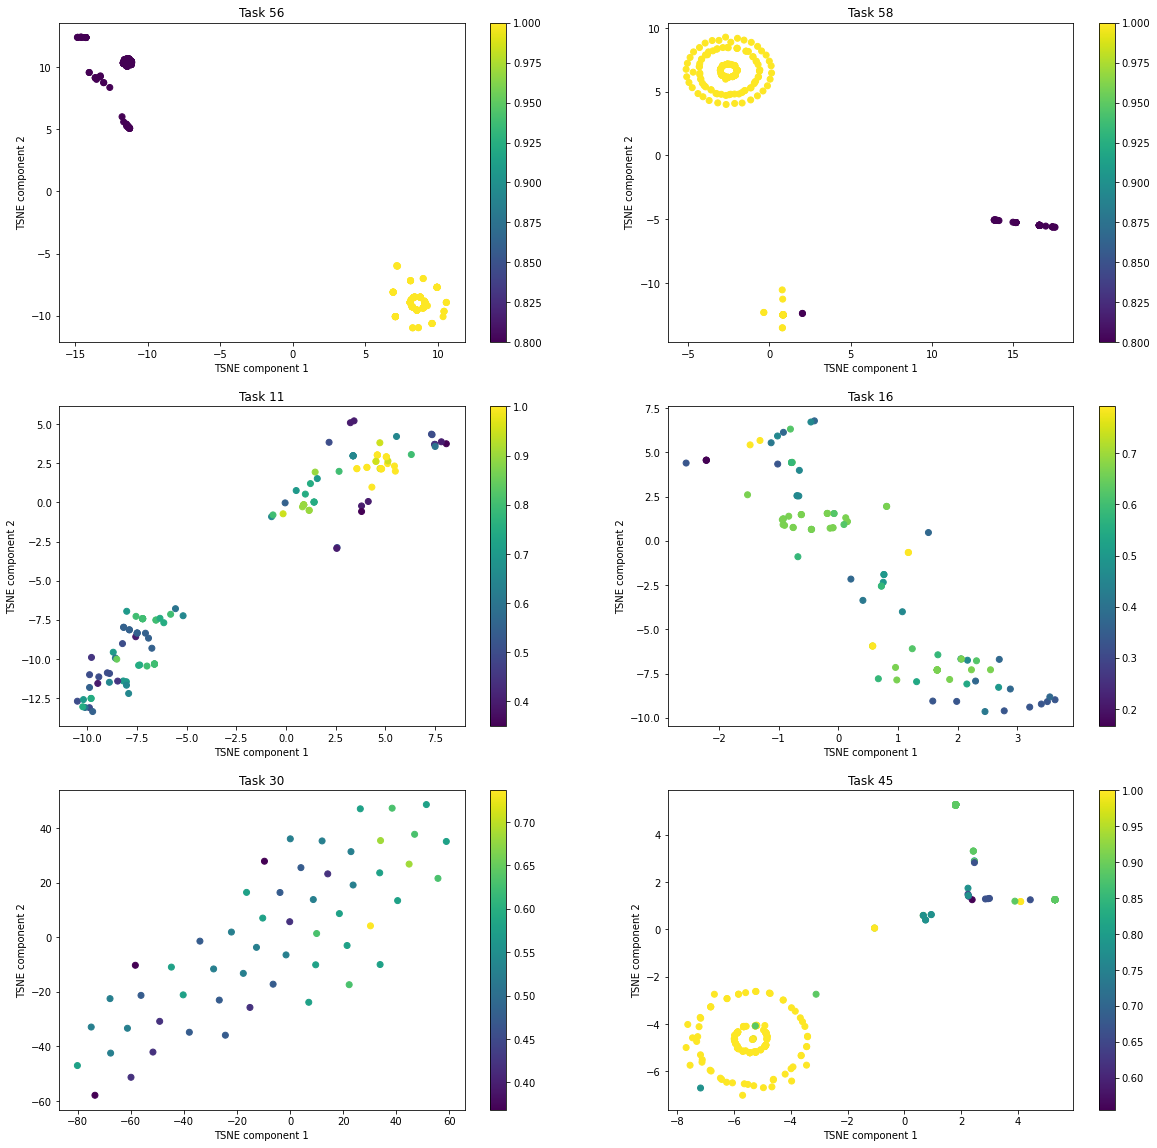

In [114]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))

for item, plt_row, plt_col in zip([56, 58, 11, 16, 30, 45],
                                  [0, 0, 1, 1, 2, 2],
                                  [0, 1, 0, 1, 0, 1]):
    task_df = compute_features(item, correct_only=True)
    
    # Drop unnecessary columns
    task_df_trimmed = task_df.drop(['id', 'item', 'user', 'time', 'answer', 'code', 'moves', 'responseTime', 
                                    'correct', 'codeLength', 'sim_perc_sol', 'sim_perc_closest'],
                                    axis=1)
    
    # TSNE
    X_embedded = TSNE(n_components=2).fit_transform(task_df_trimmed.values)
    vector0 = [x[0] for x in X_embedded]
    vector1 = [x[1] for x in X_embedded]
    
    ax = axes[plt_row, plt_col]
    im = ax.scatter(x=vector0, y=vector1, c=task_df['sim_perc_sol'])
    ax.set_title("Task {}".format(item))
    ax.set_ylabel('TSNE component 2')
    ax.set_xlabel('TSNE component 1')
    fig.colorbar(im, ax=ax)

plt.show()

In [27]:
task_df_trimmed.head()

,ast_len,def,print,loop,ifelse,math,compare,assign
563,5,1,1,1,0,0,0,0
564,5,1,1,1,0,0,0,0
565,5,1,1,1,0,0,0,0
592,9,1,1,1,0,1,0,0
654,11,1,1,1,1,3,1,2


## Most frequent solutions

Top 3

[56, 58, 11, 16, 30, 45]

In [88]:
item = 30
task_df = compute_features(item, correct_only=True)

# Drop unnecessary columns
task_df_trimmed = task_df.drop(['id', 'item', 'user', 'time', 'answer', 'code', 'moves', 'responseTime', 
                                'correct', 'codeLength', 'sim_perc_closest'],
                                axis=1)

top_3_df = task_df_trimmed.groupby(task_df_trimmed.columns.tolist(),as_index=False).size().reset_index().\
      rename(columns={0:'count'}).sort_values(by=['count'], ascending=False).reset_index(drop=True).head(3)

print("Task", item)
print(top_3_df)

top_3_df = top_3_df.drop(['count'], axis=1)

most_freq_1 = pd.merge(task_df, top_3_df.loc[[0]], how='inner', on=top_3_df.columns.tolist())
most_freq_2 = pd.merge(task_df, top_3_df.loc[[1]], how='inner', on=top_3_df.columns.tolist())
most_freq_3 = pd.merge(task_df, top_3_df.loc[[2]], how='inner', on=top_3_df.columns.tolist())

Task 30
   sim_perc_sol  ast_len  def  print  loop  ifelse  math  compare  assign  \
0      0.368421       29    1      0     1       0     0        0       2   
1      0.578947       29    1      0     2       4     1        4       7   
2      0.526316       57    1      0     2       4     1        2      10   

   count  
0      1  
1      1  
2      1  


In [89]:
most_freq_1.code.values

array(['def most_common(mylist):\n    ord_list = []\n    ord_list.extend(set(mylist))\n    counter_list = []\n    for i in range(len(ord_list)):\n        counter_list.append(mylist.count(ord_list[i]))\n    return ord_list[counter_list.index(max(counter_list))]'],
      dtype=object)

In [90]:
most_freq_2.code.values

array(['def most_common(mylist):\n    most=0\n    high_freq = 0\n    freq=0\n    for x in mylist:\n        for y in mylist:\n            if x==y:\n                freq+=1\n        if freq > high_freq:\n            high_freq=freq\n            most=x\n        elif freq==high_freq:\n            if x<most:\n                most=x\n        freq=0\n    return most'],
      dtype=object)

In [91]:
most_freq_3.code.values

array(['def most_common(mylist):\n    nums = {}\n    for num in mylist:\n        if num in nums:\n            curr_value = nums.pop(num)\n            new_value = int(curr_value) + 1\n            nums[num] = new_value\n        else:\n            nums[num] = 1\n    new_nums = sorted(nums, key=lambda x: nums[x], reverse=True)\n    max_num = new_nums[0]\n    for i in range(len(new_nums)):\n        if nums[max_num] == nums[new_nums[i]]:\n            if new_nums[i] < max_num:\n                max_num = new_nums[i]\n    return max_num\n'],
      dtype=object)

Solution

In [92]:
solution = questions_df.at[item, 'solution'][2:-2].split(',')[1].replace('"', '')
solution = decode_program(solution)
solution

'def most_common(mylist):    \n    mylist = sorted(mylist)\n    max_value, max_count = None, 0\n    current_value, current_count = None, 0\n    for value in mylist:\n        if value == current_value:\n            current_count += 1\n        else:\n            current_value = value\n            current_count = 1\n        if current_count > max_count:\n            max_value = current_value\n            max_count = current_count\n    return max_value\n'

## Most frequent mistakes / bad solutions

In [93]:
item = 30
task_df = compute_features(item, incorrect_only=True)

# Drop unnecessary columns
task_df_trimmed = task_df.drop(['id', 'item', 'user', 'time', 'answer', 'code', 'moves', 'responseTime', 
                                'correct', 'codeLength', 'sim_perc_sol'],
                                axis=1)

top_3_df = task_df_trimmed.groupby(task_df_trimmed.columns.tolist(),as_index=False).size().reset_index().\
      rename(columns={0:'count'}).sort_values(by=['count'], ascending=False).reset_index(drop=True).head(3)

print("Task", item)
print(top_3_df)

top_3_df = top_3_df.drop(['count'], axis=1)

most_freq_1 = pd.merge(task_df, top_3_df.loc[[0]], how='inner', on=top_3_df.columns.tolist())
most_freq_2 = pd.merge(task_df, top_3_df.loc[[1]], how='inner', on=top_3_df.columns.tolist())
most_freq_3 = pd.merge(task_df, top_3_df.loc[[2]], how='inner', on=top_3_df.columns.tolist())

Task 30
   ast_len  sim_perc_closest  def  print  loop  ifelse  math  compare  assign  \
0        5          0.800000    1      0     0       0     0        0       0   
1       16          0.750000    1      0     1       0     0        1       5   
2       36          0.222222    1      0     2       3     1        4       7   

   count  
0     13  
1      4  
2      2  


In [94]:
most_freq_1.code.values

array(['def most_common(mylist):\n    return 0\n',
       'def most_common(mylist):\n    return 0\n',
       'def most_common(mylist):\n    return 3\n',
       'def most_common(mylist):\n    return 0\n',
       'def most_common(mylist):\n    return 0\n',
       'def most_common(mylist):\n    return 0\n',
       'def most_common(mylist):\n    return 0\n',
       'def most_common(mylist):\n    return 0\n',
       'def most_common(mylist):\n    ff\n    return 0\n',
       'def most_common(mylist):\n    return 0\npičovina\n',
       'def most_common(mylist):\n    return 0\n',
       'def most_common(mylist):\n    \n    return 0\n',
       'def most_common(mylist):\n    return 0\n'], dtype=object)

In [95]:
most_freq_2.code.values

array(['def most_common(mylist):\n    counter = 0\n    num = mylist[0]\n    \n    for i in mylist:\n        curr_frequency = mylist.count(i) \n        if(curr_frequency> counter): \n            counter = curr_frequency \n            num = i\n   \t\n    return num\n',
       'def most_common(mylist):\n    counter = 0\n    num = mylist[0]\n    \n    for i in mylist:\n        curr_frequency = mylist.count(i) \n        if(curr_frequency > counter): \n            counter = curr_frequency \n            num = i\n   \t\n    return num\n',
       'def most_common(mylist):\n    counter = 0\n    num = mylist[0]\n    \n    for i in mylist:\n        curr_frequency = mylist.count(i) \n        if(curr_frequency > counter):\n            counter = curr_frequency \n            num = i\n   \t\n    return num\n',
       'def most_common(mylist):\n    counter = 0\n    num = mylist[0]\n    for i in mylist:\n        curr_frequency = mylist.count(i) \n        if(curr_frequency > counter):\n            counter

In [96]:
most_freq_3.code.values

array(['def most_common(mylist):\n    max_oc = 0\n    max_oc_num = 0\n    for i in range(len(mylist)):\n        oc = 0\n        for j in range(len(mylist)):\n            if mylist[i] == mylist[j]:\n            \toc += 1\n        if max_oc < oc:\n            max_oc = oc\n            max_oc_number = mylist[i]\n        if max_oc == oc and max_oc_number < mylist[i]:\n            max_oc = oc\n            max_oc_number = mylist[i]\n    return max_oc\n',
       'def most_common(mylist):\n    max_oc = 0\n    max_oc_num = 0\n    for i in range(len(mylist)):\n        oc = 0\n        for j in range(len(mylist)):\n            if mylist[i] == mylist[j]:\n            \toc += 1\n        if max_oc < oc:\n            max_oc = oc\n            max_oc_number = mylist[i]\n        if max_oc == oc and max_oc_number < mylist[i]:\n            max_oc = oc\n            max_oc_number = mylist[i]\n    return max_oc_number\n'],
      dtype=object)

# TODO

Zistiť, u ktorých úloh sú riešenia blízko vzorovému a u ktorých nie - tie sú možno ťažšie?

Zistiť, u ktorých úloh sa často vyskytuje nejaká skupina zlých riešení - časté chyby.

## Poznámky

Prefiltroval som duplikáty (tie isté odovzdania od toho istého človeka). 

U niektorých úloh sú úlohy detekované mojim feature vektorom ako rozdielne, ale v podstate sú rovnaké (napr. použitie for item in items vs for i in range(len(items))).

Niektoré časté chyby nie sú naozaj chyby iba "lenivé odovzdanie" alebo ako to nazvať... Žiaden kód, return 0. Časté chyby by sa dali z toho vytiahnuť možno tak, že si nájdem tie najčastejšie chyby tak ako to tu robím, prefiltrujem to od tohto odpadu lenivých riešení, prípadne cheatovacích riešení, a nájsť v tom nejaké skutočné programátorské chyby. Jednu takú som napr. našiel pri or and podmienkach - if a == 2 or 3

Nižšie som detekoval 5 úloh, ktoré nemajú typické riešenia.

uloha 24 nejak blbne, neda sa spracovat

## Zaujimave ulohy
Vacsie zhluky nespravnych rieseni: 2,5,7,11,16,17,18,26,27,30

Malo vzorovych rieseni: 3,5,9,10,11,12,13,14,16,17,18,25,26,27,28,29,30

Ziadne zhluky rieseni: 2,4,12,13,16,18,26,28,30

25-30 nemali skoro ziadne vzorove riesenia

### Najdenie uloh s castymi chybami

In [109]:
freq_mistakes = []
items = [i for i in range(1, 75)]
items.remove(24)

for item in items:
    task_df = compute_features(item, incorrect_only=True)

    # Drop unnecessary columns
    task_df_trimmed = task_df.drop(['id', 'item', 'user', 'time', 'answer', 'code', 'moves', 'responseTime', 
                                    'correct', 'codeLength', 'sim_perc_sol'],
                                    axis=1)

    top_3_df = task_df_trimmed.groupby(task_df_trimmed.columns.tolist(),as_index=False).size().reset_index().\
          rename(columns={0:'count'}).sort_values(by=['count'], ascending=False).reset_index(drop=True).head(3)
    
    if top_3_df['count'].max() >= 20:
        freq_mistakes.append(item)

print(freq_mistakes)

[1, 7, 8, 17, 20, 32, 33, 34, 35, 36, 37, 38, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 54, 62, 63, 66, 68]


### Najdenie uloh bez clusterov spravnych rieseni

In [110]:
no_solution_clusters = []
items = [i for i in range(1, 75)]
items.remove(24)

for item in items:
    task_df = compute_features(item, correct_only=True)

    # Drop unnecessary columns
    task_df_trimmed = task_df.drop(['id', 'item', 'user', 'time', 'answer', 'code', 'moves', 'responseTime', 
                                    'correct', 'codeLength', 'sim_perc_sol'],
                                    axis=1)

    top_3_df = task_df_trimmed.groupby(task_df_trimmed.columns.tolist(),as_index=False).size().reset_index().\
          rename(columns={0:'count'}).sort_values(by=['count'], ascending=False).reset_index(drop=True).head(3)
    
    if top_3_df['count'].max() <= 2:
        no_solution_clusters.append(item)
        
no_solution_clusters

[28, 30, 69, 73, 74]